In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import os

In [6]:
def load_data(data_dir):
    images, labels = [], []
    
    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)

        if not os.path.isdir(class_path):
            continue  
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            if img_name.startswith("."):
                continue  

            try:
                img = Image.open(img_path).convert("L").resize((28, 28))  
                img_array = np.array(img).astype(np.float32) / 255.0  
                images.append(img_array.flatten())  
                labels.append(int(class_label))  
            except Exception as e:
                print(f"Skipping file: {img_name}, Error: {e}")

    return np.array(images), np.array(labels)

train_images, train_labels = load_data("fashion/train")
test_images, test_labels = load_data("fashion/test")

In [7]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [8]:
class ANN:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate=0.01):
        self.lr = learning_rate
        np.random.seed(42)  

        self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        self.b1 = np.zeros((1, hidden_size1))

        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        self.b2 = np.zeros((1, hidden_size2))

        self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = softmax(self.Z3)

        return self.A3

    def compute_loss(self, Y_pred, Y_true):
        m = Y_true.shape[0]
        log_probs = -np.log(Y_pred[range(m), Y_true])
        return np.mean(log_probs)

    def backward(self, X, Y_true):
        m = X.shape[0]

        Y_one_hot = np.zeros_like(self.A3)
        Y_one_hot[np.arange(m), Y_true] = 1

        dZ3 = self.A3 - Y_one_hot
        dW3 = (self.A2.T @ dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = (self.A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X_train, Y_train, epochs=10, batch_size=32):
        for epoch in range(epochs):
            shuffle_idx = np.random.permutation(len(X_train))
            X_train, Y_train = X_train[shuffle_idx], Y_train[shuffle_idx]

            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                Y_batch = Y_train[i:i+batch_size]

                Y_pred = self.forward(X_batch)
                self.backward(X_batch, Y_batch)

            train_loss = self.compute_loss(self.forward(X_train), Y_train)
            train_acc = self.evaluate(X_train, Y_train)
            print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}, Accuracy = {train_acc:.2f}%")

    def evaluate(self, X, Y):
        predictions = np.argmax(self.forward(X), axis=1)
        return np.mean(predictions == Y) * 100

    def predict(self, image):
        output = self.forward(image.reshape(1, -1))
        return np.argmax(output)

In [9]:
model = ANN(input_size=28*28, hidden_size1=128, hidden_size2=64, output_size=10, learning_rate=0.01)
model.train(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1: Loss = 1.5187, Accuracy = 36.03%
Epoch 2: Loss = 0.8754, Accuracy = 67.50%
Epoch 3: Loss = 0.7560, Accuracy = 73.34%
Epoch 4: Loss = 0.6877, Accuracy = 73.99%
Epoch 5: Loss = 0.5861, Accuracy = 79.40%
Epoch 6: Loss = 0.5588, Accuracy = 80.57%
Epoch 7: Loss = 0.5133, Accuracy = 82.31%
Epoch 8: Loss = 0.4804, Accuracy = 83.41%
Epoch 9: Loss = 0.4690, Accuracy = 83.57%
Epoch 10: Loss = 0.4450, Accuracy = 84.50%


In [10]:
test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 83.06%


In [11]:
def predict_image(image_path):
    img = Image.open(image_path).convert("L").resize((28, 28))
    img_array = np.array(img).astype(np.float32) / 255.0
    predicted_class = model.predict(img_array.flatten())
    return predicted_class

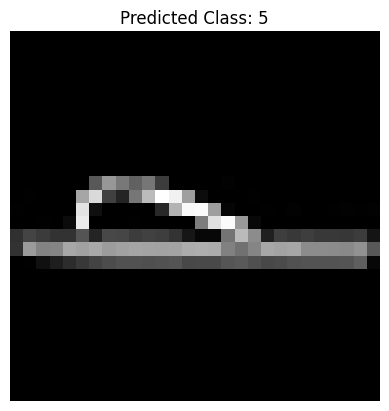

In [12]:
sample_image_path = "fashion/test/5/1037.png"
predicted_class = predict_image(sample_image_path)
plt.imshow(Image.open(sample_image_path).convert("L"), cmap='gray')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

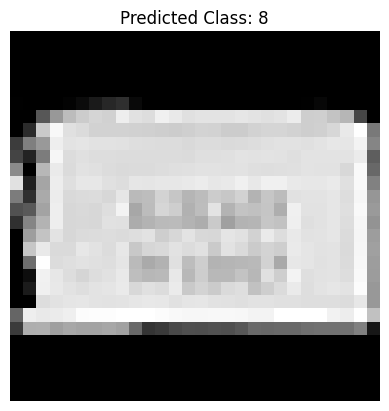

In [13]:
sample_image_path = "fashion/test/8/1961.png"
predicted_class = predict_image(sample_image_path)
plt.imshow(Image.open(sample_image_path).convert("L"), cmap='gray')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()